# Importing the USA's Airspaces

We import data on the USA's airspaces from [a dataset provided by the FAA](https://adds-faa.opendata.arcgis.com/datasets/c6a62360338e408cb1512366ad61559e_0).
This data already contains all the information we need so it requires very little processing.

## Setup

In [1]:
import requests
from datetime import datetime, timezone
import time
import numpy as np
import pandas as pd
import descartes, geopandas
from shapely.geometry import LineString, Point, Polygon, MultiPolygon, base
from shapely.ops import transform

import math
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature

## Initial Data Processing

We download the file using a built-in geopandas method, and do some basic processing to get the geometry and vertical limits into formats that the rest of the processing code can work with.

In [2]:
url = "https://opendata.arcgis.com/datasets/c6a62360338e408cb1512366ad61559e_0.geojson"
gdf = geopandas.read_file(url)

NOTE: as it turns out the z-coordinate is completely unused so `vertical_limits` is unnecessary. I'm leaving it here in case it comes in handy later.

In [3]:
def vertical_limits(geom):
    def _limits_from_coords(c):
        l = list(map(lambda t: t[2], list(c)))
        return (min(l), max(l))
    
    if isinstance(geom, Polygon):
        return _limits_from_coords(geom.exterior.coords)
    elif isinstance(geom, MultiPolygon):
        lims = list(map(list, zip(*[ _limits_from_coords(g.exterior.coords) for g in geom ])))
        return (min(lims[0]), max(lims[1]))
    else:
        raise NotImplementedError

In [4]:
def process_geometry(shape):
    shape2 = transform(lambda x, y, z: tuple(filter(None, [x, y])), shape).buffer(0)
    if isinstance(shape2, Polygon):
        return MultiPolygon([shape2])
    elif isinstance(shape2, MultiPolygon):
        return shape2
    else:
        raise NotImplementedError

def process_vertical_limits(upper, upper_units, lower, lower_units):
    if upper_units == "FT":
        upper_ft = int(upper)
    elif upper_units == "FL":
        upper_ft = int(upper) * 100
    else:
        upper_ft = 1000000 # Assume 'None' is unrestricted, this should be large enough
    if upper_ft < 0:
        upper_ft = 1000000 # See above
    
    if lower_units == "FT":
        lower_ft = int(lower)
    elif lower_units == "FL":
        lower_ft = int(lower) * 100
    else:
        lower_ft = 0 # Assume 'None' is unrestricted, return ground level
    return (upper_ft, lower_ft)

gdf['geometry'] = gdf.geometry.apply(process_geometry)
gdf['upper_limit'], gdf['lower_limit'] = zip(*gdf.apply(lambda row: process_vertical_limits(row.UPPER_VAL, row.UPPER_UOM, row.LOWER_VAL, row.LOWER_UOM), axis=1))
gdf['name'] = gdf['NAME']
del gdf['NAME']
gdf

,OBJECTID,GLOBAL_ID,IDENT,ICAO_ID,UPPER_DESC,UPPER_VAL,UPPER_UOM,UPPER_CODE,LOWER_DESC,LOWER_VAL,...,AK_LOW,US_LOW,US_AREA,PACIFIC,Shape__Area,Shape__Length,geometry,upper_limit,lower_limit,name
0,1,2AC361E6-08A9-49E8-8B3B-AA68EE41363C,CZYZ,CZYZ,TI,17999,FT,MSL,None,4500,...,0,1,0,0,1.655436,7.583659,"MULTIPOLYGON (((-81.20495 44.50579, -81.20936 ...",17999,4500,"TORONTO, ON CAE 8"
1,2,3B2EA57E-2618-47A3-BC52-DF07A2DB6F97,CZWG,CZWG,TI,17999,FT,MSL,None,12501,...,0,1,0,0,4.581230,8.016952,"MULTIPOLYGON (((-95.96780 49.79961, -95.96764 ...",17999,12501,"KENORA, ON CAE"
2,3,E229E560-CA7D-45A7-AFD6-9FF3E01113C6,CZVR,CZVR,TI,12500,FT,MSL,None,2000,...,1,1,0,0,0.074797,1.798322,"MULTIPOLYGON (((-122.55477 49.10081, -122.5547...",12500,2000,PITT MEADOWS CAE
3,4,7099FA1B-406E-4896-BA81-F74E30AECFCE,CZVR,CZVR,TI,6500,FT,MSL,None,3200,...,1,0,0,0,0.016077,0.598732,"MULTIPOLYGON (((-123.50967 49.37969, -123.5091...",6500,3200,"VANCOUVER, BC TCA"
4,5,7FD391DB-1145-44CF-A32F-64B192FA284E,CZYZ,CZYZ,TI,3300,FT,MSL,None,0,...,0,1,0,0,0.030340,0.630070,"MULTIPOLYGON (((-76.71478 44.22523, -76.71477 ...",3300,0,"KINGSTON, ON CTLZ"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5794,5795,C471BE9C-6BBD-4DB6-8809-490E740EA021,NOW,KNOW,TI,2500,FT,MSL,None,0,...,1,1,0,1,0.002927,0.197640,"MULTIPOLYGON (((-123.41226 48.11634, -123.4149...",2500,0,PORT ANGELES CGAS CLASS E2
5795,5796,4DCDB3FC-9149-4A58-B040-7F668E971B5D,NOW,KNOW,AA,-9998,None,None,None,0,...,1,1,0,1,0.008285,0.475549,"MULTIPOLYGON (((-123.39775 48.11881, -123.3968...",1000000,0,PORT ANGELES CGAS CLASS E4
5796,5797,D76D7CA4-4715-4991-AD59-DF1A7003A3EA,None,None,AA,-9998,None,None,None,700,...,0,1,0,1,0.049059,0.895362,"MULTIPOLYGON (((-124.52673 42.55188, -124.4869...",1000000,700,GOLD BEACH CLASS E5
5797,5798,F9D11D29-3001-4E66-A8C5-62BF1232E64B,None,None,AA,-9998,None,None,None,1200,...,0,1,0,1,0.262581,1.855594,"MULTIPOLYGON (((-124.42158 42.16528, -124.4240...",1000000,1200,GOLD BEACH CLASS E5


## Visualising Airspaces

We can now plot the airspaces on a map.

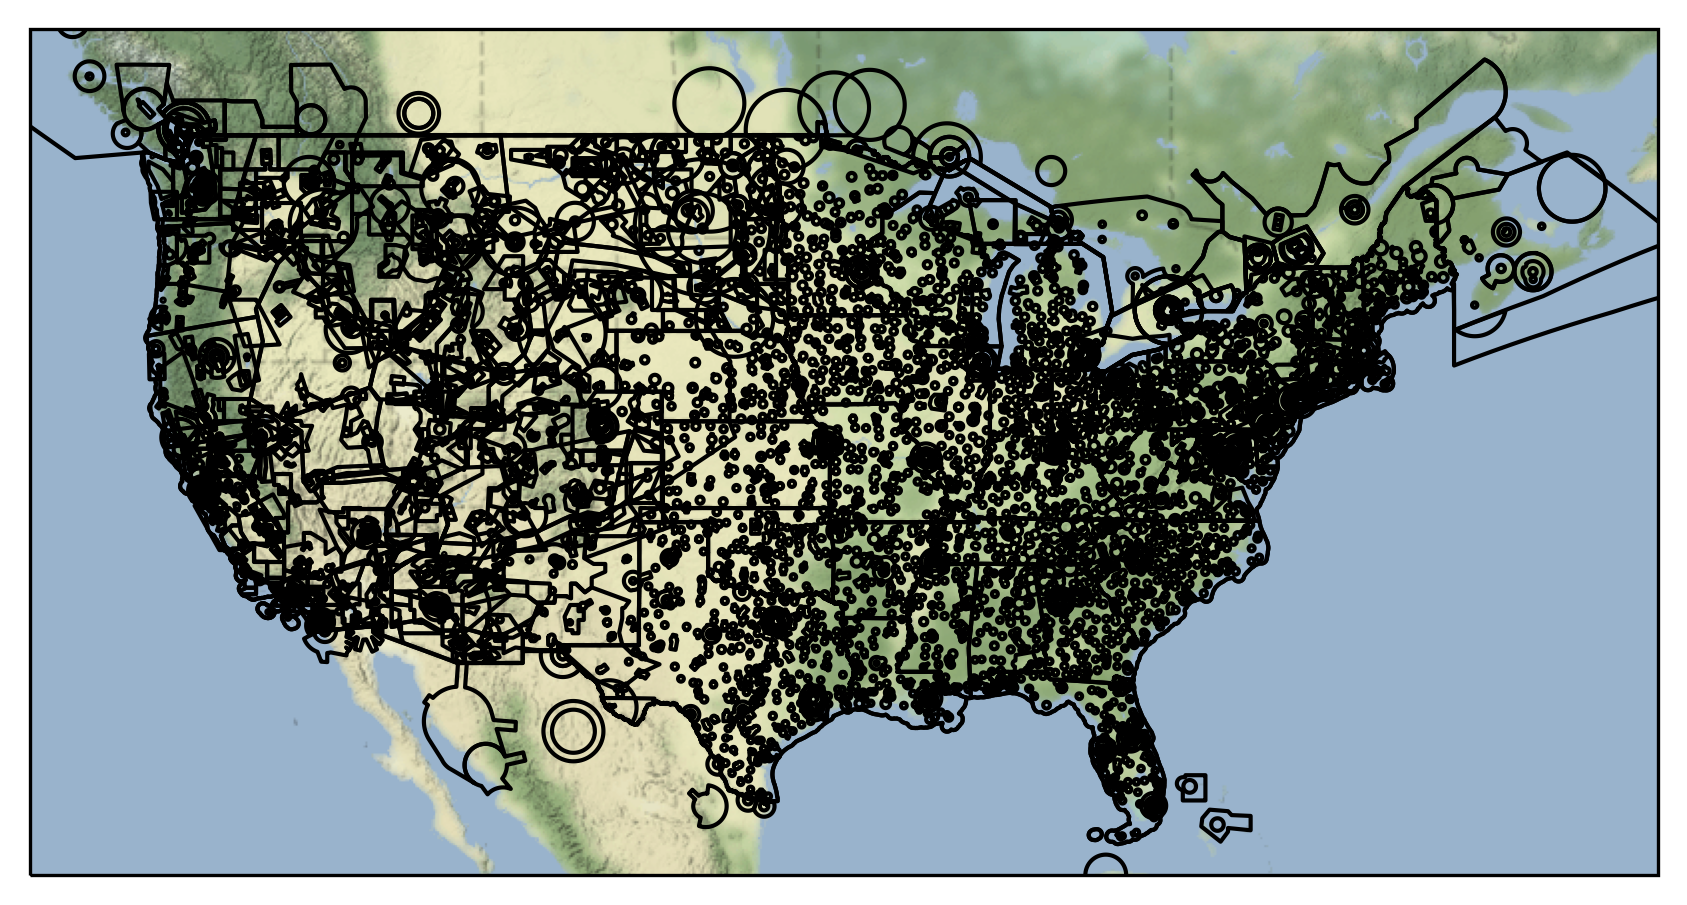

In [5]:
fig = plt.figure(dpi=300, figsize=(7,7))

imagery = cimgt.Stamen(style="terrain-background")
ax = plt.axes(projection=imagery.crs)

minlon = -130
maxlon = -58
minlat = 23
maxlat = 46

ax.set_extent((minlon, maxlon, minlat, maxlat))
ax.add_image(imagery, 4)

ax.add_geometries(gdf.geometry, crs=ccrs.PlateCarree(), facecolor="none", edgecolor="black")

ax.set_aspect('auto')

plt.show()

## Export Data

We save the data to a file.

In [6]:
from flight_processing import DataConfig

In [7]:
config = DataConfig.known_dataset("usa")
out_location = config.dataset_location
out_location

'/mnt/cold_data/josh/processing/regions_usa_wkt.json'

In [ ]:
gdf_out = gdf.copy()

gdf_out['wkt'] = gdf_out.geometry.apply(lambda g: g.wkt)

gdf_out.to_file(out_location, driver="GeoJSON")

del gdf_out